Problem Set 01 :
------------------------------------------------------------------------------------------------------
The dataset comprises 5,863 JPEG X-Ray images and is categorised into two types (Pneumonia and Normal), organised into three folders: train, test, and val. Each folder contains subfolders for each image type.

These chest X-ray images (anterior-posterior view) were sourced from paediatric patients aged one to five years at a renowned hospital. The X-rays were part of the routine clinical care of these patients.

As a data scientist working in the healthcare industry, your task is to develop a convolutional neural network (CNN) model that can classify medical images into their respective categories. The model should be able to accurately identify the type of medical image shown in an image, based on the image itself.

In [1]:
import os
import glob
import numpy as np
import pandas as pd

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#ML libraries
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

#DL libraries
import tensorflow as tf
from keras.preprocessing import image
from keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

#Setting a seed
np.random.seed(22)

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

2024-01-20 17:16:53.474867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-20 17:17:00.375623: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-20 17:17:00.383948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-20 17:17:10.564582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
def get_data(path,label):
    files=np.array(os.listdir(path))

    labels=np.array([label]*len(files))

    images=[]
    for image in files:
        image=cv2.imread(path+image)
        image=cv2.resize(image,dsize=(200,200))
        image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        images.append(image)

    images=np.array(images)

    return images,labels

In [13]:
normal_images,normal_labels=get_data('Archive/train/NORMAL/','normal')
pneumonia_images,pneumonia_labels=get_data('Archive/train/PNEUMONIA/','pneumonia')

normal_images_test,normal_labels_test=get_data('Archive/test/NORMAL/','normal')
pneumonia_images_test,pneumonia_labels_test=get_data('Archive/test/PNEUMONIA/','pneumonia')

In [14]:
X_train=np.append(normal_images,pneumonia_images,axis=0)
y_train=np.append(normal_labels,pneumonia_labels)

X_test=np.append(normal_images_test,pneumonia_images_test,axis=0)
y_test=np.append(normal_labels_test,pneumonia_labels_test)

print("Image size: ",X_train.shape)
print("Label size: ",y_train.shape)
print("Labels: ",np.unique(y_train))

Image size:  (5216, 200, 200)
Label size:  (5216,)
Labels:  ['normal' 'pneumonia']


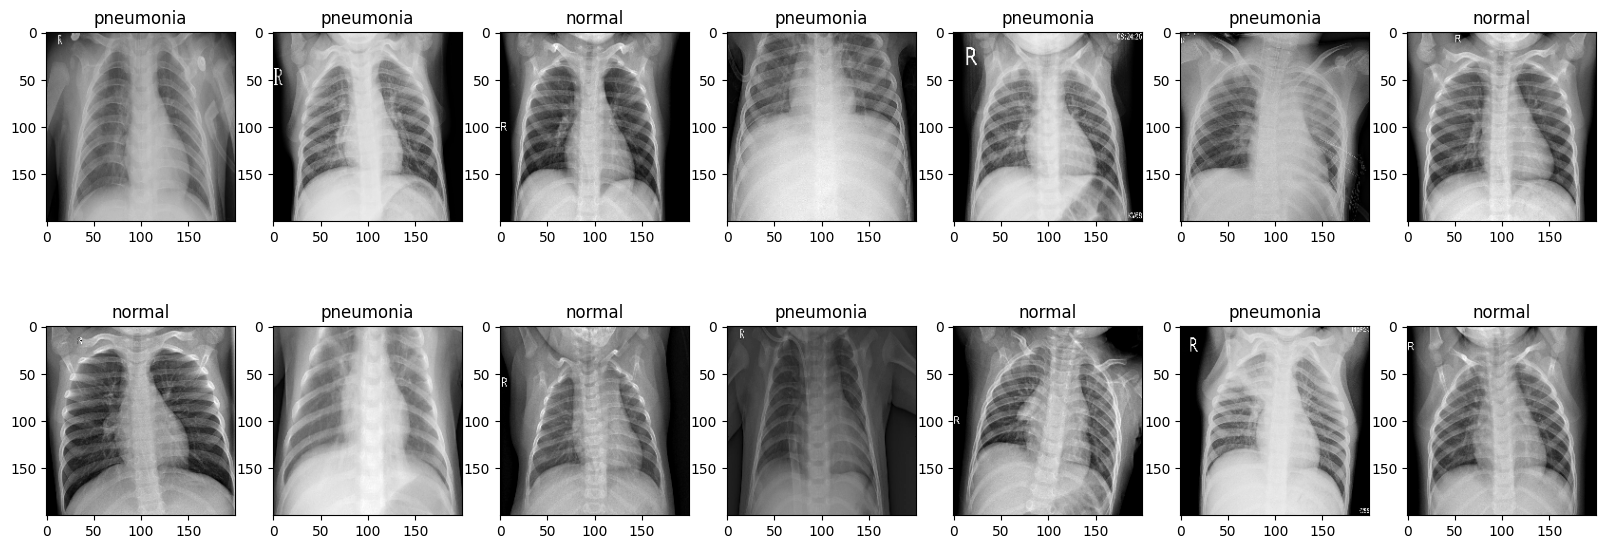

In [15]:
fig,ax=plt.subplots(ncols=7,nrows=2,figsize=(20,7))

indices=np.random.choice(len(X_train),14)
counter=0

#Displaying subplots of images with labels
for i in range(2):
    for j in range(7):
        ax[i,j].set_title(y_train[indices[counter]])
        ax[i,j].imshow(X_train[indices[counter]],cmap='gray')
        counter+=1

plt.show()

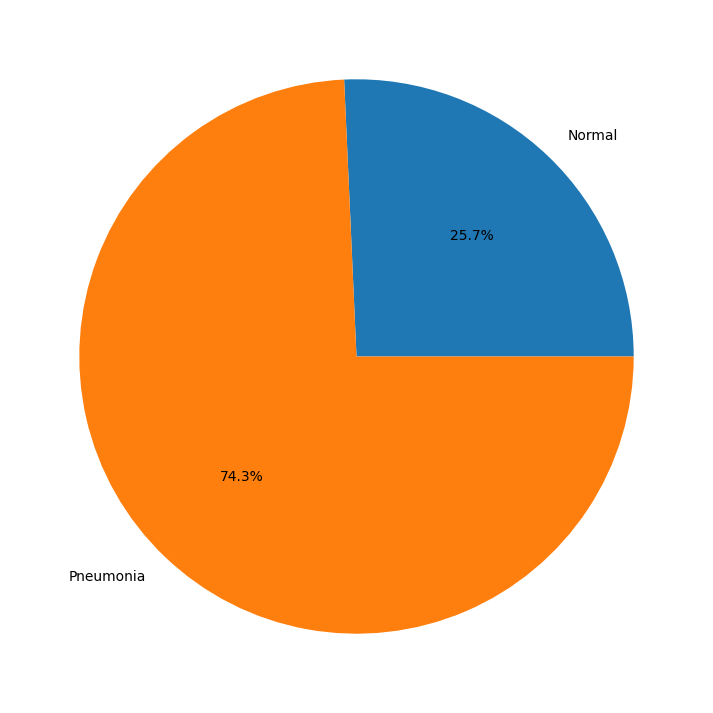

In [16]:
labels=['Normal','Pneumonia']

targets=[len(normal_images),len(pneumonia_images)]

plt.figure(figsize=(16,9))
plt.pie(x=targets,labels=labels,autopct="%1.1f%%")
plt.show()

In [17]:
y_train=y_train[:,np.newaxis]
y_test=y_test[:,np.newaxis]

encode=OneHotEncoder(sparse=False)

y_train_encode=encode.fit_transform(y_train)
y_test_encode=encode.transform(y_test)

In [18]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [19]:
#Data augumentation
datagen=ImageDataGenerator(
rotation_range=10,
zoom_range=0.1,
width_shift_range=0.1,
height_shift_range=0.1)

datagen.fit(X_train)

#Applying the data augumentation on all training and testing images
traingen=datagen.flow(X_train,y_train_encode,batch_size=32)
testgen=datagen.flow(X_test,y_test_encode,batch_size=32)

In [20]:
#CNN architecture
model=tf.keras.models.Sequential([
    #Input layer
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(200,200,1)),
    tf.keras.layers.MaxPooling2D(2,2),

    #Hidden layer 1
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    #Hidden layer 2
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    #Hidden layer 3
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    #Flatten layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),

    #Output layer
    tf.keras.layers.Dense(2,activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 batch_normalization (Batch  (None, 97, 97, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                        

In [25]:
history=model.fit_generator(traingen,epochs=10,validation_data=(X_test,y_test_encode))

Epoch 1/10
163/163 [==============================] - 234s 1s/step - loss: 0.0966 - accuracy: 0.9651 - val_loss: 1.2429 - val_accuracy: 0.5769
Epoch 2/10
163/163 [==============================] - 232s 1s/step - loss: 0.0913 - accuracy: 0.9664 - val_loss: 0.5790 - val_accuracy: 0.7933
Epoch 3/10
163/163 [==============================] - 246s 2s/step - loss: 0.0946 - accuracy: 0.9657 - val_loss: 0.2455 - val_accuracy: 0.9038
Epoch 4/10
163/163 [==============================] - 266s 2s/step - loss: 0.0841 - accuracy: 0.9653 - val_loss: 0.6490 - val_accuracy: 0.7724
Epoch 5/10
163/163 [==============================] - 260s 2s/step - loss: 0.0872 - accuracy: 0.9664 - val_loss: 0.3566 - val_accuracy: 0.8494
Epoch 6/10
163/163 [==============================] - 237s 1s/step - loss: 0.0801 - accuracy: 0.9703 - val_loss: 0.5415 - val_accuracy: 0.8429
Epoch 7/10
163/163 [==============================] - 239s 1s/step - loss: 0.0732 - accuracy: 0.9726 - val_loss: 0.5289 - val_accuracy: 0.8189

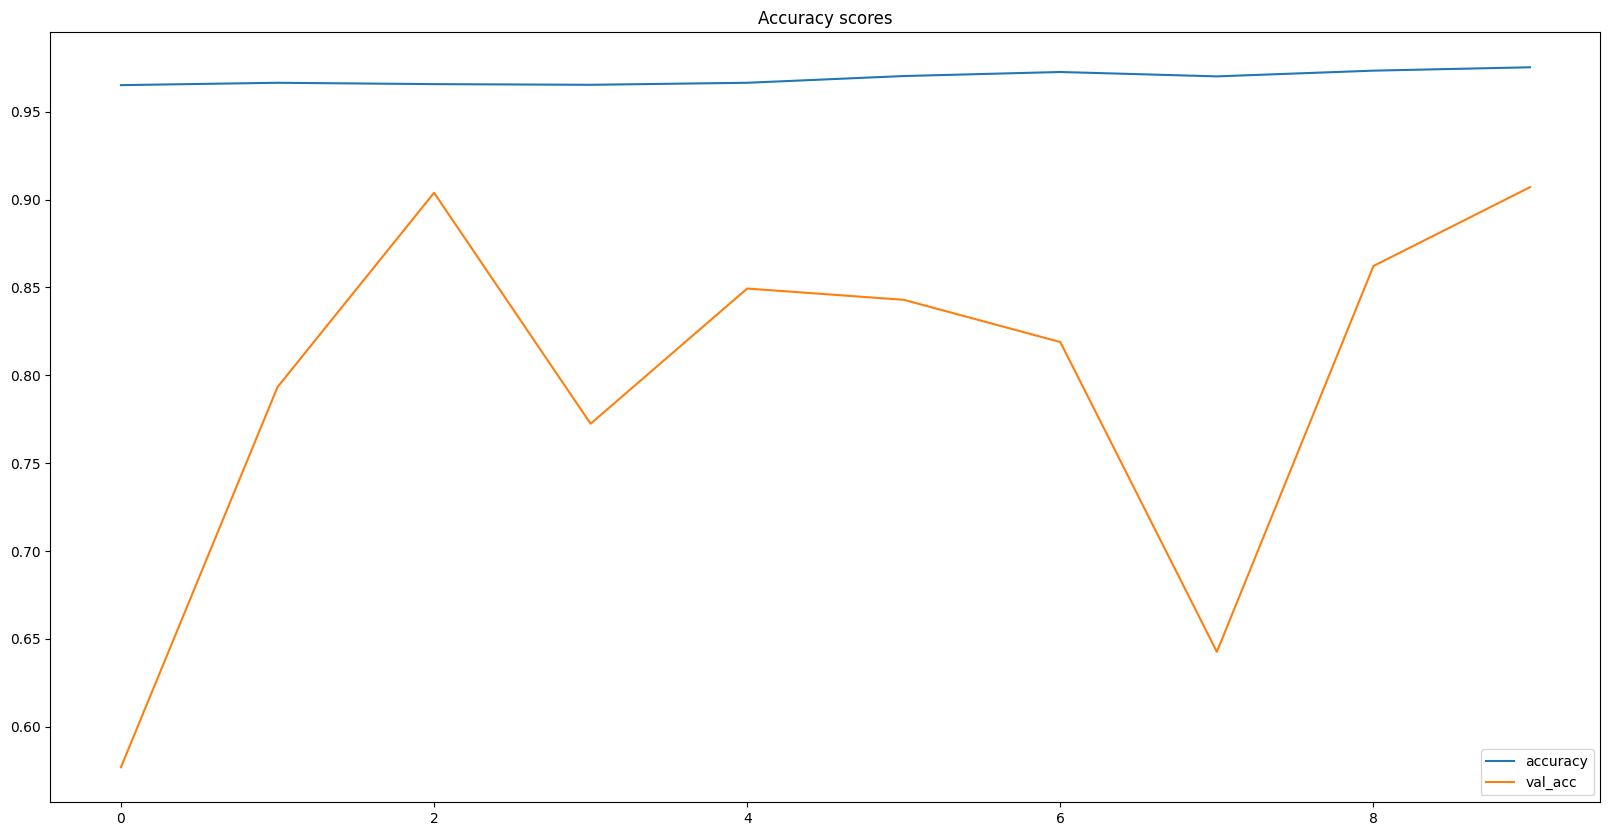

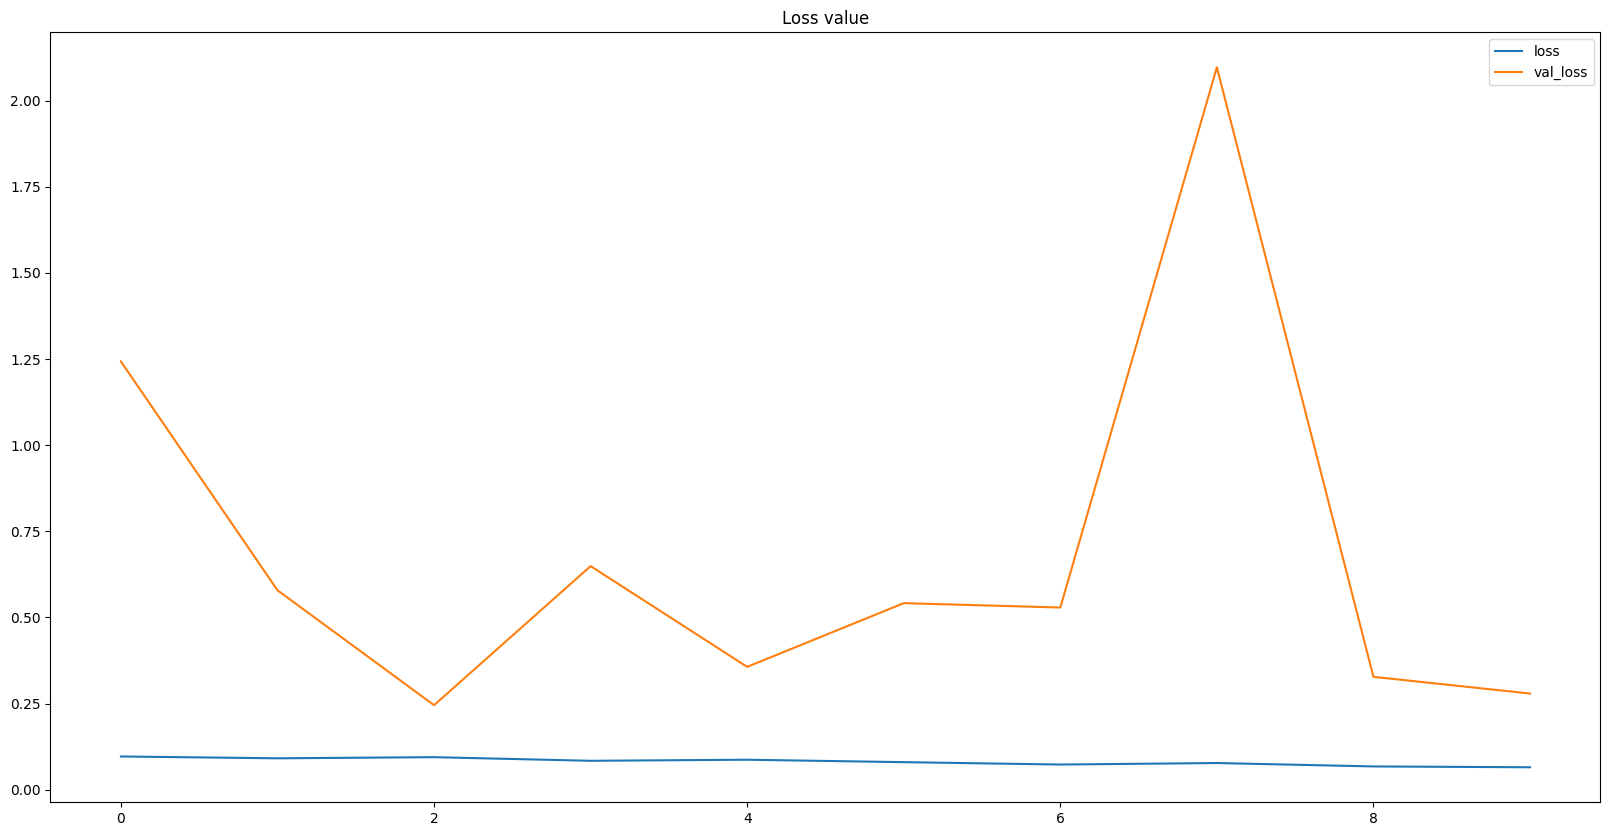

In [26]:
#Setting up image size
plt.figure(figsize=(20,10))

#Plot train and validation accuracy
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_acc'])
plt.show()

#Plot train and validation loss
plt.figure(figsize=(20,10))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

20/20 [==============================] - 6s 316ms/step


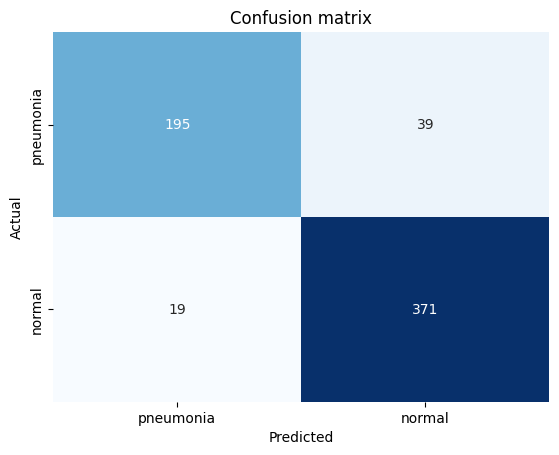

In [27]:
#predicting the model on test data
predictions=model.predict(X_test)

#Inverse transform the encoded images
predictions=encode.inverse_transform(predictions)

#Creating confusion matrix
cm=confusion_matrix(y_test,predictions)

#Plotting confusion matrix
labels=['pneumonia','normal']
plt.title('Confusion matrix')
sns.heatmap(cm,cbar=False,xticklabels=labels,yticklabels=labels,fmt='d',annot=True,cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [28]:
#Calculating classification metrics
tn,fp,fn,tp=cm.ravel()
precision=tp/(tp+fp)*100
recall=tp/(tp+fn)*100
F1score=(2*precision*recall/(precision+recall))

print("Precision:",precision)
print("Recall:",recall)
print("F1 score:",F1score)

eval_result=model.evaluate_generator(testgen,624)
print("Accuracy:{}%".format(round(eval_result[1]*100,2)))

Precision: 90.48780487804878
Recall: 95.12820512820512
F1 score: 92.75
Accuracy:84.29%
